In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas
import os, shutil, time, pdb, random, pickle
import scipy.stats as stats 

from IPython.display import clear_output

from math import pi
from datetime import datetime
from collections import OrderedDict

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [2]:
from importlib import reload
from models import *
from utils import *
from runmanager import *
from experiment import *
from plot_utils import *
from preprocessing_utils import *
from elbo import *

In [3]:
# from shapely.geometry import box, mapping
# import descartes

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
%matplotlib inline
# import seaborn as sns
# sns.set_theme()
pd.options.display.max_columns = None

np.random.seed(4)

%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.rc_file_defaults()

In [4]:
from plum import dispatch
from varz.torch import Vars
import torch.nn as nn
from stheno.torch import B, GP, EQ, Normal, Measure
from matrix import Diagonal

# Detect device.
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [5]:
from gp_mlp import *

In [6]:
# # Import Beas and Sutlej shapefiles
# beas_shp = '/Users/marron31/Google Drive/PhD/gis/exports/beas_watershed.shp'
# sutlej_shp = '/Users/marron31/Google Drive/PhD/gis/exports/sutlej_watershed.shp'

# beas = geopandas.read_file(beas_shp)
# sutlej = geopandas.read_file(sutlej_shp)

# catchments = beas.append(sutlej)

In [7]:
# Let all of Stheno run on that device.
B.device(device).__enter__()
B.epsilon = 1e-1  # Needs to be relatively high for `float32`s
# B.epsilon is the default value for the diagonal jitter of the matrix

/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/lab/generic.py:296: DeprecationWarning: The use of `device` to change the active device is deprecated. Please use `on_device` instead.
  warnings.warn(


In [8]:
# Parameters
start="1900-01-01"
end="2020-12-31"

TRAIN_PATH = "../../data/norris/enriched_obs/enriched_langtang_obs_norris_ready.pkl"
TRAIN_PATH = '../../data/idaweb/observations_enriched_WRF.pkl'
# TEST_PATH = "../data/pickle/df_stations_val_all_nonzero_extended.pkl"
# TRAIN_PATH = '../../data/idaweb/observations_enriched_WRF.pkl'

In [9]:
"""

df = pd.read_pickle('../../data/idaweb/observations_enriched_WRF.pkl')
# df.rename(columns={"stn":"Station"}, inplace=True)

# Calculate Day of Year
df['DOY'] = df['date'].dt.dayofyear

# Apply cosine and sine transformations
# Note: np.cos and np.sin expect radians, so we scale DOY to [0, 2π] range
df['doy_sin'] = np.cos(2 * np.pi * df['DOY'] / 365.25)
df['doy_cos'] = np.sin(2 * np.pi * df['DOY'] / 365.25)

df.rename(columns={'Elevation [m]':'Z'},inplace=True)

df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
df['Z'] = pd.to_numeric(df['Z'], errors='coerce')
# df = df.dropna()


df = df[['Station', 
# 'time', 'rka150d0', 'qrka150d0', 'mrka150d0', 'date', 'rre150d0', 'qrre150d0', 'mrre150d0', 'rka150d0_flag', 'rre150d0_flag',
   'month', 'year', 'Prec', 
#     'Name', 'Data source', 'Longitude/Latitude', 'Coordinates [km]', 
    'Z', 
#     'Lon', 'Lat', 
    'X', 'Y', 'Date',
         'doy_sin','doy_cos',
   'W500', 'RH2', 'U500', 'V10', 'RH500', 'RAIN', 'U10', 'V500', 'T2MIN','T2', 'T2MAX']]

df = df.dropna()

df = df.drop_duplicates(subset=['X','Y','Z','RAIN','doy_sin', 'doy_cos','year'])

df.to_pickle('../../data/idaweb/observations_enriched_WRF_reduced.pkl')

"""

'\n\ndf = pd.read_pickle(\'../../data/idaweb/observations_enriched_WRF.pkl\')\n# df.rename(columns={"stn":"Station"}, inplace=True)\n\n# Calculate Day of Year\ndf[\'DOY\'] = df[\'date\'].dt.dayofyear\n\n# Apply cosine and sine transformations\n# Note: np.cos and np.sin expect radians, so we scale DOY to [0, 2π] range\ndf[\'doy_sin\'] = np.cos(2 * np.pi * df[\'DOY\'] / 365.25)\ndf[\'doy_cos\'] = np.sin(2 * np.pi * df[\'DOY\'] / 365.25)\n\ndf.rename(columns={\'Elevation [m]\':\'Z\'},inplace=True)\n\ndf[\'X\'] = pd.to_numeric(df[\'X\'], errors=\'coerce\')\ndf[\'Y\'] = pd.to_numeric(df[\'Y\'], errors=\'coerce\')\ndf[\'Z\'] = pd.to_numeric(df[\'Z\'], errors=\'coerce\')\n# df = df.dropna()\n\n\ndf = df[[\'Station\', \n# \'time\', \'rka150d0\', \'qrka150d0\', \'mrka150d0\', \'date\', \'rre150d0\', \'qrre150d0\', \'mrre150d0\', \'rka150d0_flag\', \'rre150d0_flag\',\n   \'month\', \'year\', \'Prec\', \n#     \'Name\', \'Data source\', \'Longitude/Latitude\', \'Coordinates [km]\', \n    \'Z\', \

In [10]:
TRAIN_PATH = '../../data/idaweb/observations_enriched_WRF_reduced.pkl'

In [11]:
predictant = ['Prec']
predictors = [
              #'Date',
              #'Station',
              #'Prec',
              #'Corrected Station Name', 
              'X', 'Y',
              #'Altitude (m)', 
#               'Z', 
#               'RAIN', #'wrf_bc_prcp', 
              #'elev_hr', 
              #'aspect','slope', 
              #'doy', 
              'doy_sin', 'doy_cos', 
              'W500', 'RH2', 'U500', 'V10', 'RH500', 'RAIN', 'U10', 'V500', 'T2MIN',
              'T2', 'T2MAX'
              #'wrf_prcp_-1', 'wrf_prcp_-2','wrf_prcp_1', 'wrf_prcp_2', 
              #'Basin', 'lon', 'lat', 
#               'era5_u', 'era5_v',
              #'era5_u_-2', 'era5_u_-1', 'era5_u_1', 'era5_u_2', 
              #'era5_v_-2', 'era5_v_-1', 'era5_v_1', 'era5_v_2'
             ]

In [12]:
# root_folder = '../../data/norris/enriched_obs/enriched_langtang_obs_norris_ready.pkl'

In [13]:
TEST_PATH = r'/users/marron31/data/idaweb/maps_for_predictions/1991-06-03.csv'

In [14]:
stations_langtang = ['Tipping Bucket Lama Hotel', 
                    'Tipping Bucket Langtang',
                   'Tipping Bucket Kyanjing', 
#                    'Tipping Bucket Numthang old',
#                    'Tipping Bucket Jathang', 
#                     'Pluviometer Yala', 
#                     'AWS Kyangjing',
#                    'AWS Yala BC', 
                    'Tipping Bucket Ganja La 3',
                   'Tipping Bucket Ganja La 2',
                   'Tipping Bucket Langshisha Glacier (next to Pluviometer)',
                   'Tipping Bucket Ganja La 1',
                    'Tipping Bucket Langshisha BC',
                   'Tipping Bucket Shalbachum',
#                    'Pluviometer Langshisha Glacier (off-glacier)',
                   'Pluviometer GanjaLa', 'Pluviometer Morimoto']

exclusion_list = ['Tipping Bucket Numthang old', 'Tipping Bucket Jathang',
                   'Pluviometer Langshisha Glacier (off-glacier)', 'Pluviometer Yala',
                   'AWS Kyangjing', 'AWS Yala BC']

[s not in exclusion_list for s in stations_langtang]

sublist = ['AWS Kyangjing', 'AWS Yala BC', 'Pluviometer Yala']

In [15]:
# pick 10% random stations for validation, 10% for testing and the rest for training
stations = list(pd.read_pickle(TRAIN_PATH).Station.unique())
random.shuffle(stations)
val_stations = stations[:int(len(stations)*0.1)]
test_stations = stations[int(len(stations)*0.1):int(len(stations)*0.2)]
train_stations = stations[int(len(stations)*0.2):]

In [16]:
ds_dataset = UpperIndusDataset(TRAIN_PATH, start, end, predictant, predictors, stations=train_stations)
ds_dataset_val = UpperIndusDataset(TRAIN_PATH, start, end, predictant, predictors, stations=val_stations)
# ds_dataset_test = UpperIndusDataset(TRAIN_PATH, start, end, predictant, predictors, stations=test_stations)
# ds_dataset_map = UpperIndusDataset(TEST_PATH, start, end, predictant, predictors, stations=test_stations)

train_mean = ds_dataset.mean
train_var = ds_dataset.var

dataloader = DataLoader(dataset=ds_dataset, batch_size=16, shuffle=True)
dataloader_val = DataLoader(dataset=ds_dataset, batch_size=16, shuffle=True)
# dataloader_test = DataLoader(dataset=ds_dataset, batch_size=16, shuffle=True)

train_dataloader = dataloader
val_dataloader = dataloader_val
# test_dataloader = dataloader_test

/users/marron31/repos/upper-indus-prec-bc/preprocessing_utils.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[series][df[series] < 0] = 0
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/xarray/core/pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/xarray/core/pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/xarray/core/pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version ins

In [17]:
# ds_dataset_map = MapDataset(TEST_PATH, predictors, train_mean, train_var)

# dataloader_map = DataLoader(dataset=ds_dataset_map, batch_size=1, shuffle=False)

In [18]:
model = MLP(in_channels= len(predictors)-1, 
            hidden_channels=[10,10], 
            likelihood_fn='bgmm', # 'gamma', 'ggmm', bgmm', 'b2gmm', 'b2sgmm'
            dropout_rate=0,
           )

print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 293


In [19]:
MLP = MLP(in_channels= len(predictors), 
            hidden_channels=[10,10], 
            likelihood_fn='bgmm', # 'gamma', 'ggmm', bgmm', 'b2gmm', 'b2sgmm'
            dropout_rate=0,
           )

print(f'Number of parameters: {sum(p.numel() for p in MLP.parameters())}')

Number of parameters: 303


In [20]:
model.to(device)
MLP.to(device);

In [21]:
def reset_weights(m):
    '''
    This function resets model weights randomly following the original initialization method.
    Works for simple architectures and commonly used layers.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            # If the layer has the method `reset_parameters`, it will be called
            layer.reset_parameters()

In [22]:
MLP.apply(reset_weights);

In [23]:
model.apply(reset_weights);

In [24]:
print_progress = True
plot_x_ind = True
validate_flag = True
f_marginal_flag = False
mc_samples = 10

In [25]:
# arr, _ = UpperIndusGridDataset(root_folder, train_mean, train_var).__getitem__(10)

# x_min = arr[0,:].min()
# x_max = arr[0,:].max() 
# y_min = arr[1,:].min()
# y_max = arr[1,:].max()

In [26]:
st = ds_dataset.st
x_ind_stations = st.groupby('Station').mean()[['X','Y']].values
x_ind_stations.shape

(199, 2)

In [27]:
train_losses = []
val_losses = []
test_losses = []

train_loader = dataloader
valid_loader = dataloader
test_loader = dataloader

epochs = 10

optimizer = torch.optim.Adam(MLP.parameters(), lr=0.00001)

for epoch in range(epochs):
    
    MLP.train()
    
    for i, (inputs, labels) in enumerate(train_dataloader):
        
    inputs = inputs.to(device)
    labels = labels.to(device)
    
#     MORE TEXT
    
    
#     train_loss, val_loss, test_loss = train_epoch(MLP, optimizer, train_loader, valid_loader, test_loader=test_loader, 
                                                  print_progress=True, epoch=epoch, device=device, permute=True)
    
    
        
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

In [28]:
# Number of points for inducing points grid
# x_points = 30
# y_points = 30

#  Grid of equally spaced points covering the spatial extent for which station data is available
# grid = np.meshgrid(np.linspace(st['X'].min(),st['X'].max(),x_points),np.linspace(st['Y'].min(),st['Y'].max(),y_points))
# grid = np.meshgrid(np.linspace(x_min,x_max,x_points),np.linspace(y_min,y_max,y_points))

# Make grid into a tensor
# grid = torch.tensor(grid, dtype=torch.float32).flatten(start_dim=1).permute(1,0)

# x_ind = grid.clone().detach().requires_grad_(True)
# num_ind_points = x_points * y_points
    
# Inducing points are points in the station
x_ind = torch.tensor(x_ind_stations, dtype=torch.float32).detach().requires_grad_(False).to(device)
num_ind_points = len(x_ind)

n = len(st)

train_loss, train_loglik, train_kl = [], [], []
val_loss, val_loglik, val_kl = [], [], []
test_loss, test_loglik, test_kl = [], [], []

train_loss_batch, train_loglik_batch, train_kl_batch = RunningAverage(), RunningAverage(), RunningAverage()
val_loss_batch, val_loglik_batch, val_kl_batch = RunningAverage(), RunningAverage(), RunningAverage()

# model.train()
# prior = Measure()

with Measure() as prior:
    f1 = GP(EQ().stretch(0.5))
    #f2 = GP(EQ().stretch(2))
    #f3 = GP(EQ().stretch(0.5))
    f = f1 #+ f2 + f3

# f = GP(EQ().stretch(0.5)) # f is drawn from a GP
 
q = ApproximatePosterior(num_ind_points) # q is the approximate posterior

# optimizer = torch.optim.Adam(list(model.parameters())+list(q.parameters())+[x_ind], lr=10e-3)
optimizer = torch.optim.Adam(list(model.parameters())+list(q.parameters()), lr=10e-6)

In [ ]:
num_epochs = 20

torch.cuda.empty_cache()
for e in range(num_epochs):
    
    # TRAIN EPOCH
    
    model.train()
        
#     if plot_x_ind and (e % 10 == 0):
#         fig, ax = plt.subplots(figsize=(5,5))
#         ax.scatter(x_ind.detach()[:,0].cpu(),
#                    x_ind.detach()[:,1].cpu()
#                   )
#         plt.show()

    start = time.time()

    train_loss_batch.reset()
    train_loglik_batch.reset()
    train_kl_batch.reset()
    val_loss_batch.reset()
    val_loglik_batch.reset()
    val_kl_batch.reset()

    n = train_dataloader.dataset.n
    
    
    for i, (inputs, labels) in enumerate(train_dataloader):
        
#         inputs = torch.nan_to_num(inputs)
#         labels = torch.nan_to_num(labels)
#         masks - 

        # inputs [batch_size, num_predictors, num_stations]
        # labels [batch_size, num_stations ]

        inputs = inputs.to(device)
        labels = labels.to(device)

        elbo, recon, kl, num_points = forward_backward_pass(inputs, labels, n, model, optimizer, q, f, x_ind, 
                                                            inducing_points=True, backward=True, f_marginal=f_marginal_flag, n_samples=mc_samples)

        # Keep track of loss terms
        train_loss_batch.update(-elbo.item())
        train_loglik_batch.update(-recon.item()/num_points)
        train_kl_batch.update(kl.item())

    elapsed = time.time() - start

    if print_progress:
        print(f'Average values for training epoch {e}: -elbo: {train_loss_batch.avg:.4f} | kl: {train_kl_batch.avg:.4f} | -log-lik: {train_loglik_batch.avg:.4f} -- time elapsed: {elapsed:.2f}')
    
    # Add average batch loss terms to lists
    train_loss.append(train_loss_batch.avg)
    train_loglik.append(float(train_loglik_batch.avg.cpu()))
    train_kl.append(train_kl_batch.avg)
    
    if validate_flag:

        # VALIDATION EPOCH

        model.eval()

        n = dataloader_val.dataset.n
        
        start = time.time()

        with torch.no_grad():

            for i, (inputs, labels) in enumerate(dataloader_val):
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                elbo, recon, kl, num_points = forward_backward_pass(inputs, labels, n, model, optimizer, q, f, x_ind, 
                                                                    inducing_points=True, backward=False, f_marginal=f_marginal_flag, n_samples=mc_samples*20)

                # Keep track of loss terms
                val_loss_batch.update(-elbo.item())
                val_loglik_batch.update(-recon.item()/num_points)
                val_kl_batch.update(kl.item())

        elapsed_val = time.time() - start

        if print_progress:
            print(f'Average values for validation epoch {e}: -elbo: {val_loss_batch.avg:.4f} | kl: {val_kl_batch.avg:.4f} | -log-lik: {val_loglik_batch.avg:.4f} -- time elapsed: {elapsed_val:.2f}')

        # Add average batch loss terms to lists
        val_loss.append(val_loss_batch.avg)
        val_loglik.append(val_loglik_batch.avg)
        val_kl.append(val_kl_batch.avg)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

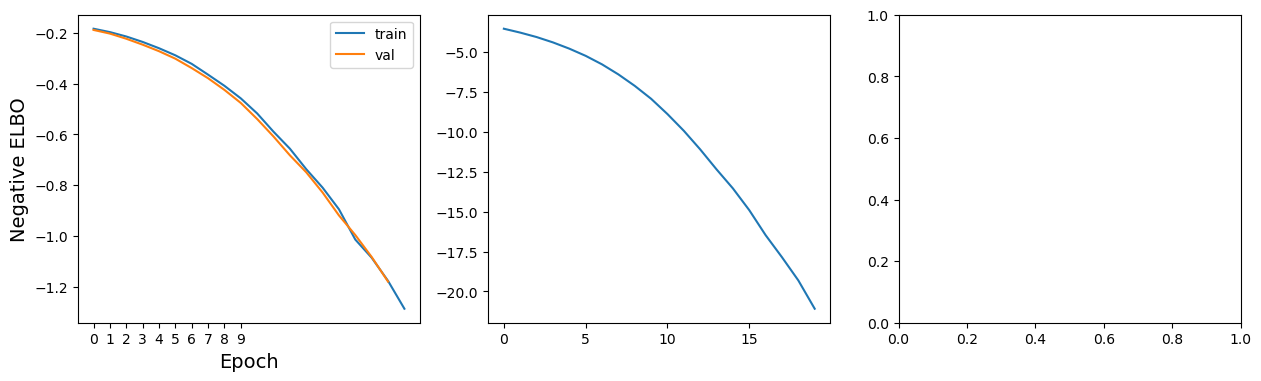

In [30]:
train_vars = [train_loss, train_loglik, train_kl] 
validation_vars = [val_loss, val_loglik, val_kl]

labels = ['Negative ELBO','Negative log likelihood term','KL divergence term']

fig, axes = plt.subplots(1,3, figsize=(15,4))
for i,ax in enumerate(axes.flatten()):
    ax.plot(train_vars[i], label='train')
    ax.plot(validation_vars[i], label='val')
    ax.legend()
#     ax.set_title(f'{labels[i]} | best: {np.min(train_vars[i]):.2f}')
    ax.set_ylabel(f'{labels[i]}', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
#     ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [62]:
# test_dataloader = DataLoader(dataset=UpperIndusGridDataset(root_folder, train_mean, train_var), batch_size=1, shuffle=True)

inducing_points = True

model.eval()

with torch.no_grad():
    
    for index, (inputs, aux_inputs) in enumerate(dataloader_map):
        
        inputs = inputs[:,:,:].to(device)
        aux_inputs = aux_inputs[:,:,:].to(device)
        
        b = inputs.shape[0]
        
        if index == 0:
        
            q.build_normal()

            x = inputs[0,:2,:].permute(1,0).float()
            
            inputs = inputs[:,2:,:]
            aux_inputs = aux_inputs[:,:,:10000].to(device)

            # Sample z and concatenate to inputs
            if inducing_points:
                
                #f_sample = f_post(x).sample(b).permute(1,0).unsqueeze(1)
                
                f_post = f | (f(x_ind), q.sample())
                
                if f_marginal_flag:
                    f_sample = Normal(f_post.mean(x),
                                      Diagonal(f_post.kernel.elwise(x)[:, 0])
                                      ).sample().permute(1,0).unsqueeze(1)
                else:
                    f_sample = f_post(x).sample().permute(1,0).unsqueeze(1)
                
                inputs = torch.cat([f_sample, inputs], dim=1)
                 
            else:
                q_sample = q.sample(b).permute(1,0).unsqueeze(1)
                
                inputs = torch.cat([q_sample, inputs], dim=1)

            # Masking for missing data
            inputs = inputs.permute(0,2,1)
            aux_inputs = aux_inputs.permute(0,2,1)
 
            mask = ~torch.any(inputs.isnan(),dim=2)
            k = mask.sum()

            # Forward pass
            outputs = model(inputs[mask].float())

In [63]:
col_names = ['X','Y','wrf_prcp',
#              'doy_sin','doy_cos',
             'GPsample','pi','alpha','beta']
#col_names = ['X','Y','Z','wrf_prcp','doy_sin','doy_cos','GPsample','alpha','beta']

data = np.concatenate([aux_inputs.squeeze().cpu().numpy()[:,:2],
                       aux_inputs.squeeze().cpu().numpy()[:,9:10], # * np.sqrt(train_var[9:10]) + train_mean[9:10],
                       np.expand_dims(inputs.squeeze().cpu().numpy()[:,0], axis=1),
                       outputs.cpu().numpy()], axis=1
                       )

# pdb.set_trace()

df = pd.DataFrame(data, columns=col_names)

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.X, df.Y))

gdf['uniform'] = gdf.apply(lambda x: np.random.uniform(0,1),axis=1)
#gdf['uniform'] = np.random.uniform(0,1)

gdf['sample'] = gdf.apply(sample_apply, axis=1)

gdf['uniform'] = gdf.apply(lambda x: 0.5, axis=1)
gdf['bg_median'] = gdf.apply(sample_apply, axis=1)

gdf['g_mean'] = gdf['alpha']/gdf['beta']

gdf['p'] = 1 - gdf['pi']

x_ind_plot = x_ind.detach().cpu().numpy() * np.sqrt(train_var[:2]) + train_mean[:2] 

In [64]:
st_stations = st.groupby('Station').mean()[['X','Y']] * np.sqrt(train_var[:2]) + train_mean[:2]

<AxesSubplot:>

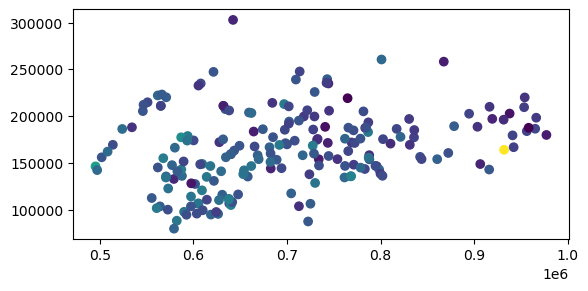

In [65]:
gdf_stations = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(x_ind_plot[:,0], x_ind_plot[:,1]))

gdf_stations['q_sample'] = q.sample().detach().cpu().numpy()
gdf_stations.plot('q_sample', cmap='viridis')

# plt.plot(gdf_stations['geometry'].x, gdf_stations['q_sample'], 'o')

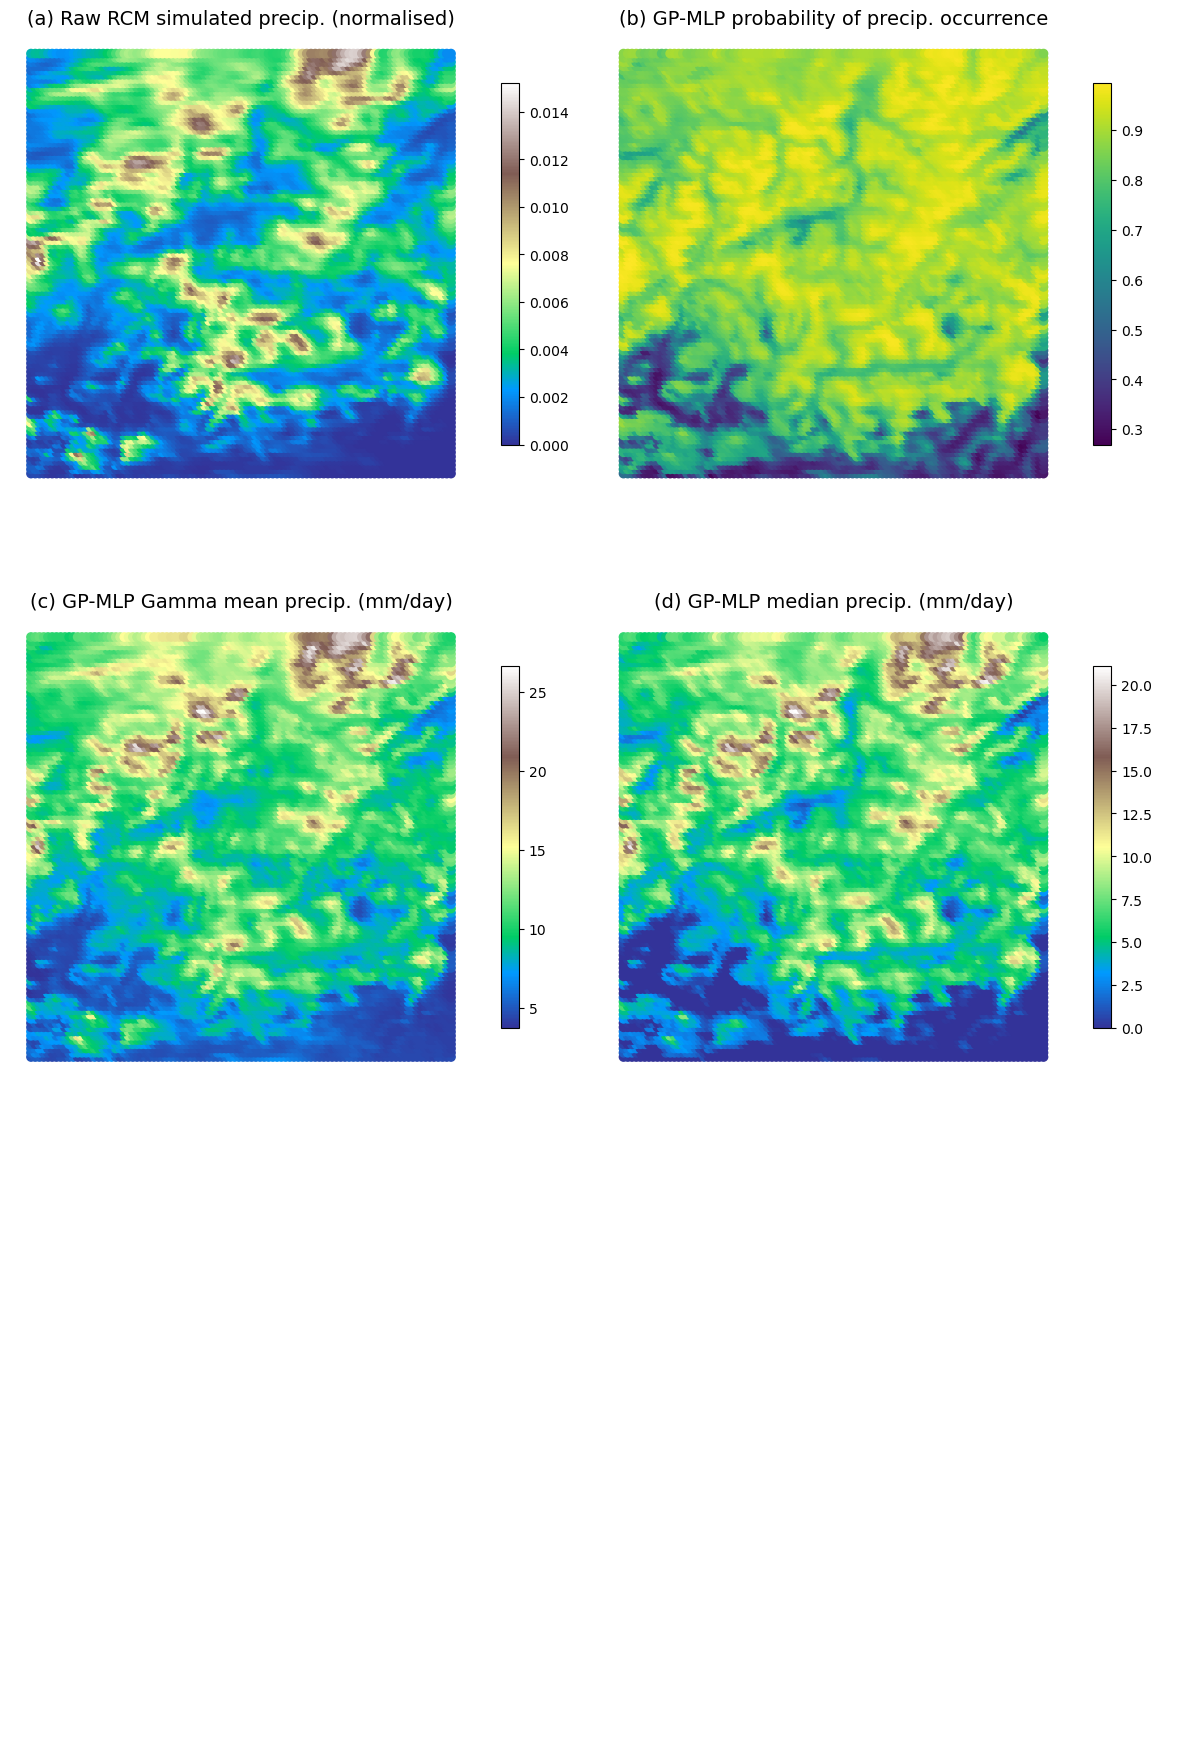

In [66]:
variables = ['wrf_prcp',
             'p',
             'g_mean',
             'bg_median',
#              'Z',
#              'sample',
#              'GPsample'
            ]

labels = ['(a) Raw RCM simulated precip. (normalised)', 
          '(b) GP-MLP probability of precip. occurrence',
          '(c) GP-MLP Gamma mean precip. (mm/day)',
          '(d) GP-MLP median precip. (mm/day)',
#           'Elevation (m.a.s.l.)',
#           '(e) BGMM sample (mm/day)', 
#           '(f) GP sample'
         ]

cmaps = ['terrain',
         'viridis',
         'terrain',
         'terrain',
#          'viridis',
#          'terrain',
#          'viridis'
        ]

fig, axes = plt.subplots(3,2,figsize=(12,18))

for idx, ax in enumerate(axes.flatten()):
    
    if idx < len(variables):
    
    #     gdf.set_crs(catchments.crs)
    #     gdf_clip = geopandas.clip(gdf, catchments)
    
        gdf.plot(variables[idx], ax=ax, legend=True, cmap=cmaps[idx], legend_kwds={'shrink': 0.6})
#         beas.plot(ax=ax, facecolor='None', edgecolor='black')
        #gdf_stations.plot(ax=ax, color='red')
        #sutlej.plot(ax=ax, facecolor='None', edgecolor='black')

        ax.set_title(labels[idx],fontsize=14)
        
        #if variables[idx]=='GPsample':
            #ax.scatter(x_ind_plot[:,0],x_ind_plot[:,1], s=4, c='r')
            #ax.scatter(st_stations['X'],st_stations['Y'], s=3, c='w')

    ax.set_frame_on(False)
    ax.set_yticks([])
    ax.set_xticks([])     

plt.tight_layout()
# plt.savefig('maps2',dpi=300)